In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import ee
import geemap 
import seaborn as sns
from datetime import datetime
from typing import List
import matplotlib as mpl

from validate_dowscaled_et import prepare_data_for_plotting

In [2]:
ee.Initialize(project="thurgau-irrigation")

### Matplotlib settings

In [ ]:
import matplotlib.pyplot as plt

# Set figure size
plt.rcParams["figure.figsize"] = (10, 6)

# Set font styles
plt.rcParams["font.size"] = 12
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = ["Times New Roman"]

# Line styles and widths
plt.rcParams["lines.linewidth"] = 2
plt.rcParams["lines.solid_capstyle"] = "round"

# Grid and ticks
plt.rcParams["grid.linestyle"] = "--"
plt.rcParams["grid.color"] = "#d3d3d3"
plt.rcParams["grid.alpha"] = 0.8
plt.rcParams["axes.grid"] = True
plt.rcParams["axes.axisbelow"] = True
plt.rcParams["xtick.direction"] = "in"
plt.rcParams["ytick.direction"] = "in"
plt.rcParams["xtick.major.size"] = 5
plt.rcParams["ytick.major.size"] = 5

# Axis properties
plt.rcParams["axes.titlesize"] = 16
plt.rcParams["axes.labelsize"] = 14
plt.rcParams["axes.labelweight"] = "bold"
plt.rcParams["axes.spines.top"] = False
plt.rcParams["axes.spines.right"] = False

# Legend
plt.rcParams["legend.fontsize"] = 12
plt.rcParams["legend.frameon"] = False

# Color cycle
plt.rcParams["axes.prop_cycle"] = plt.cycler(
    color=["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd"]
)

# Save figure settings
plt.rcParams["savefig.dpi"] = 300
plt.rcParams["savefig.bbox"] = "tight"

# Display settings for notebook or scripts
plt.rcParams["figure.autolayout"] = True

In [3]:
def store_collection_dates(collection: ee.ImageCollection) -> pd.DataFrame:
    """
    Store the dates of all images in an ImageCollection in a pandas DataFrame.

    Args:
        collection (ee.ImageCollection): The input image collection.

    Returns:
        pd.DataFrame: A pandas DataFrame containing the dates in datetime format.
    """
    dates = collection.aggregate_array("system:time_start")
    formatted_dates = dates.map(lambda d: ee.Date(d).format("YYYY-MM-dd"))
    date_list = formatted_dates.getInfo()

    date_df = pd.DataFrame({"date": pd.to_datetime(date_list)})

    return date_df

In [4]:
def set_negative_to_zero(image):
    return image.where(image.lt(0), 0)

In [5]:
def merge_et_collections(years: List[int]) -> ee.ImageCollection:
    """
    Merge ET collections for multiple years.
    
    Args:
        years (list): List of years to process.
    
    Returns:
        ee.ImageCollection: Merged ET collection for all years.
    """
    collections = [
        ee.ImageCollection(f"projects/thurgau-irrigation/assets/Thurgau/ET_WaPOR_10m_dekadal_{year}")
        .sort("system:time_start")
        .map(set_negative_to_zero)
        for year in years
    ]
    
    # Merge all collections into one
    merged_collection = collections[0]
    for collection in collections[1:]:
        merged_collection = merged_collection.merge(collection)
    
    return merged_collection

years_to_process = [2018, 2019, 2020, 2021]

# Merge all collections into one
et_collection = merge_et_collections(years_to_process)

In [6]:
dates_for_validation = store_collection_dates(et_collection)
print(dates_for_validation) 

          date
0   2018-01-01
1   2018-01-11
2   2018-01-21
3   2018-02-01
4   2018-02-11
..         ...
138 2021-11-11
139 2021-11-21
140 2021-12-01
141 2021-12-11
142 2021-12-21

[143 rows x 1 columns]


In [7]:
validation_et_collection = ee.FeatureCollection("projects/thurgau-irrigation/assets/Thurgau/ETFluxNet/ET_timeseries_rietholzbach_2017_2021").sort("system:time_start")

In [8]:
# Map = geemap.Map()
# point = validation_et_collection.first().geometry()

# image = ee.Image(et_collection.toList(144).get(50))

# Map.centerObject(point, 12)
# Map.addLayer(point, {"color": "red"}, "point")
# options = {
#     "bands": ["downscaled"],
#     "min": 0,
#     "max": 300,
#     "palette": ["blue", "white", "orange", "red"],
# }
# Map.addLayer(image, options, "ET")

# Map

In [9]:
validation_df = geemap.ee_to_df(validation_et_collection)

In [10]:
validation_df["date"] = pd.to_datetime(validation_df["date_[YYYYmmdd]"])
validation_df = validation_df.drop(columns=["date_[YYYYmmdd]"])
validation_df = validation_df.set_index("date")
validation_df = validation_df.resample("D").asfreq()
validation_df = validation_df.interpolate(method='time')


In [11]:
validation_ET = validation_df.loc[dates_for_validation['date']]
validation_ET

,evapotranspiration_[mm/d]
date,
2018-01-01,0.000
2018-01-11,0.191
2018-01-21,0.000
2018-02-01,0.000
2018-02-11,0.000
...,...
2021-11-11,0.335
2021-11-21,0.515
2021-12-01,0.958


In [12]:
def extract_pixel_values(
    image_collection: ee.ImageCollection, point: ee.Geometry.Point
) -> ee.FeatureCollection:
    """
    Extract the pixel value of the 'downscaled' band for each image in the collection
    at the specified point, with error handling for missing timestamps.

    Args:
        image_collection (ee.ImageCollection): The input image collection.
        point (ee.Geometry.Point): The point at which to extract values.

    Returns:
        ee.FeatureCollection: A feature collection where each feature represents an image
                              and contains the pixel value of the 'downscaled' band at the point.
    """

    def extract_value(image: ee.Image) -> ee.Feature:
        # Select the 'downscaled' band
        downscaled = image.select("downscaled")

        # Get the scale of the 'downscaled' band
        scale = downscaled.projection().nominalScale()

        # Extract the pixel value at the point
        pixel_value = downscaled.reduceRegion(
            reducer=ee.Reducer.first(),
            geometry=point,
            scale=scale,
            bestEffort=True,
        ).get("downscaled")

        # Retrieve the image acquisition time
        time_start = image.get("system:time_start")

        # Handle potential null time_start
        formatted_date = ee.Algorithms.If(
            ee.Algorithms.IsEqual(time_start, None),
            None,
            ee.Date(time_start).format("YYYY-MM-dd"),
        )

        return ee.Feature(
            None,
            {
                "pixel_value": pixel_value,
                "date": formatted_date,
                "system:time_start": time_start,
            },
        )

    # Map the extraction function over the image collection
    return ee.FeatureCollection(image_collection.map(extract_value))

In [13]:
point = validation_et_collection.first().geometry()
raster_collection = extract_pixel_values(et_collection, point)

In [14]:
waport_df = geemap.ee_to_df(ee.FeatureCollection(raster_collection))
waport_df["evapotranspiration[mm/d]"] = waport_df["pixel_value"] / 100
waport_df["date"] = pd.to_datetime(waport_df["date"])

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before opera

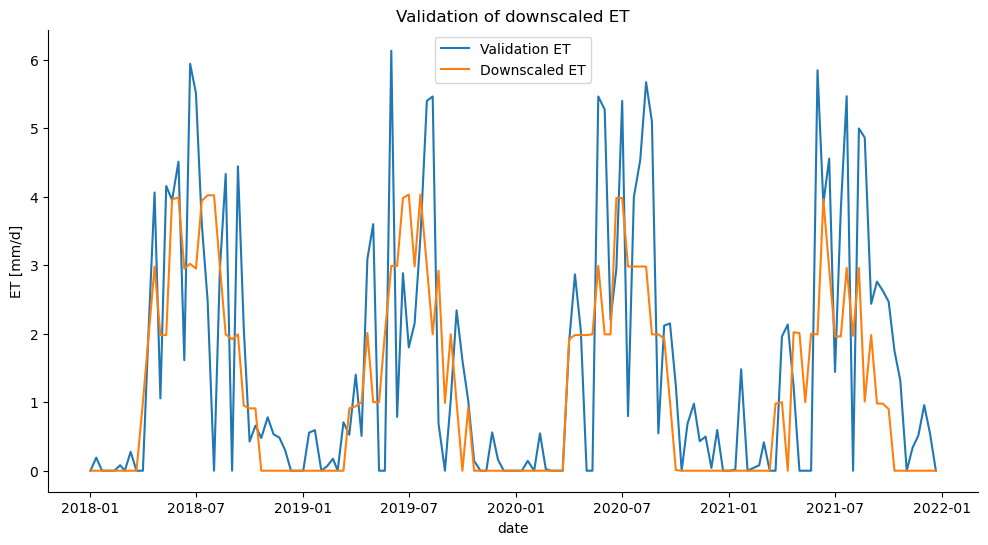

In [18]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=validation_ET, x="date", y="evapotranspiration_[mm/d]", label="Validation ET")
sns.lineplot(data=waport_df, x="date", y="evapotranspiration[mm/d]", label="Downscaled ET")
plt.ylabel("ET [mm/d]")
plt.title("Validation of downscaled ET")
sns.despine()
plt.show()